### IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed,
                                    MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D,
                                    Conv1D,Bidirectional,Concatenate,Add)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
import os
import gc
import tensorflow.keras.backend as K
import joblib

### DEVICE SETUP

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

✅ GPU is available and will be used.


### LOAD AND PREPROCESS TRAINING SET

In [3]:
# Load detection dataset
# file_path_detection = '../../data/cleaned_labeled_dataset.csv'
file_path_detection = '../../../data/cleaned_labeled_dataset.csv'
#file_path_detection = '../../data/preprocessed_data.csv'
df_detection = pd.read_csv(file_path_detection, delimiter=',')
df_detection['DateTime'] = pd.to_datetime(df_detection['DateTime'], errors='coerce')
df_detection.set_index('DateTime', inplace=True)

# List of columns to drop (replace with your actual column names)
#columns_to_drop = ['500UZ0009E01.LZI0012A.MEAS', '505D002D01.TI0012.MEAS', '530K001S01.FI0007.MEAS','530R001D01.FIC0029.MEAS']

# Drop them from both train and test dataframes
#df_detection.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Extract labels column if it exists from detection dataset
if 'labels' in df_detection.columns:
    print("✅ Found 'labels' column in detection dataset. Extracting for later evaluation.")
    labels_detection = df_detection['labels'].copy()
    df_detection_train = df_detection.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found in detection dataset. Will assume all samples are normal.")
    labels_detection = pd.Series(np.zeros(len(df_detection)))
    df_detection_train = df_detection.copy()

✅ Found 'labels' column in detection dataset. Extracting for later evaluation.


In [4]:
df_detection.shape

(28544, 23)

### LOAD AND PREPROCESS TEST SET

In [5]:
# # Load the test set from CSV
# test_set_path = '../detection_datasets/labeled_test_set_with_predictions.csv'
# df_test = pd.read_csv(test_set_path, delimiter=',')
# df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], errors='coerce')
# df_test.set_index('DateTime', inplace=True)
# print(f"✅ Loaded test set with {len(df_test)} samples from {test_set_path}")

# # Extract labels from test set if they exist
# if 'labels' in df_test.columns:
#     print("✅ Found 'labels' column in test set.")
#     all_test_labels = df_test['labels'].copy()
#     df_test_features = df_test.drop(columns=['labels'])
# else:
#     print("⚠️ No 'labels' column found in test set. Will assume all samples are normal.")
#     all_test_labels = pd.Series(np.zeros(len(df_test)))
#     df_test_features = df_test.copy()

In [6]:
scaler_detection = MinMaxScaler()

### NORMALIZE DATA

In [7]:
df_detection_train = df_detection_train[200:]

In [8]:
# Normalize detection dataset
scaled_data_detection = scaler_detection.fit_transform(df_detection_train.values)
df_detection_scaled = pd.DataFrame(scaled_data_detection, index=df_detection_train.index, 
                                  columns=df_detection_train.columns).astype(np.float32)

joblib.dump(scaler_detection, "detection_scaler.pkl")
                                  
print(f"✅ Scaled detection dataset shape: {df_detection_scaled.shape}")

✅ Scaled detection dataset shape: (28344, 22)


### CONFIGURATION

In [9]:
INPUT_STEPS = 32
TEST_RATIO = 0  # For validation split during training
TEST_SIZE_POURCENTAGE = 1
# Tuning parameters
EPOCHS_LIST = [20]
BATCH_SIZES = [32]
UNITS_LIST= [256]
# Transformer parameters for anomaly detection
DROPOUT_RATE = 0.1
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### SEQUENTIAL TRAIN/TEST SPLIT FOR MODEL EVALUATION

In [10]:
# Split for detection model
split_idx_detection = int((1 - TEST_RATIO) * len(df_detection_scaled))
train_data_detection = df_detection_scaled.iloc[:split_idx_detection]

### CREATE SEQUENCES

In [11]:
def create_sequences(data, input_steps):
    X = []
    i = 0
    while i + input_steps <= len(data):
        X.append(data[i:i+input_steps])
        i += input_steps  # advance by input_steps to avoid overlap
    return np.array(X, dtype=np.float32)

### BUILD AND TRAIN LSTM AUTOENCODER

In [12]:
#def create_ae_sequences(data, seq_len):
#    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)

def create_ae_sequences(data, input_steps):
    X = []
    i = 0
    while i + input_steps <= len(data):
        X.append(data[i:i+input_steps])
        i += input_steps  # advance by input_steps to avoid overlap
    return np.array(X, dtype=np.float32)
    
X_ae_train = create_ae_sequences(train_data_detection.values, INPUT_STEPS)

def build_lstm_autoencoder2(input_steps, input_dim, units):
    inp = Input(shape=(input_steps, input_dim))
    
    # Stacked encoder: richer context + bottleneck
    x = LSTM(units, return_sequences=True)(inp)
    
    x = Bidirectional(LSTM(units))(x)  # bottleneck (return_sequences=False)

    # Decoder
    x = RepeatVector(input_steps)(x)
    x = LSTM(units, return_sequences=True)(x)
    out = TimeDistributed(Dense(input_dim))(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    return model

In [13]:
def build_lstm_autoencoder3(input_steps, input_dim, units):
    inp = Input(shape=(input_steps, input_dim))

    # 1. Encoder: LSTM unidirectionnel + BiLSTM (bottleneck)
    x = LSTM(units, return_sequences=True)(inp)

    # BiLSTM with return_sequences=False to produce final states
    encoder_bilstm = Bidirectional(LSTM(units, return_sequences=False, return_state=True))
    context_vector, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(x)

    # 2. Decoder
    decoder_input = RepeatVector(input_steps)(context_vector)  # shape: (batch, input_steps, units*2)
    decoder_lstm = LSTM(units * 2, return_sequences=True)
    decoder_output = decoder_lstm(decoder_input,
                              initial_state=[
                                  Concatenate()([forward_h, backward_h]),
                                  Concatenate()([forward_c, backward_c])
                              ])
    decoder_output_normalized = LayerNormalization()(decoder_output)
    output = TimeDistributed(Dense(input_dim))(decoder_output_normalized)


    model = Model(inp, output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [14]:
def build_lstm_autoencoder(input_steps, input_dim, units=128):
    encoder_inputs = Input(shape=(input_steps, input_dim))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(units, return_sequences=True, return_state=True)
    )(encoder_inputs)

    # Use average encoder output as decoder input context
    context_vector = tf.reduce_mean(encoder_outputs, axis=1)
    decoder_inputs = RepeatVector(input_steps)(context_vector)

    decoder_lstm = LSTM(units * 2, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs,
                                   initial_state=[Concatenate()([forward_h, backward_h]),
                                                  Concatenate()([forward_c, backward_c])])

    #attention = MultiHeadAttention(num_heads=4, key_dim=units)
    #attention_output = attention(query=decoder_outputs, value=encoder_outputs, key=encoder_outputs)

    #combined = Concatenate()([decoder_outputs, attention_output])
    combined = LayerNormalization()(decoder_outputs)

    output = TimeDistributed(Dense(input_dim))(combined)

    model = Model(inputs=encoder_inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')  # plain MSE for now
    return model

### TRAINING/TUNING

In [25]:
history_records = []
best_model = None
best_val_loss = np.inf
best_history = None

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        for units in UNITS_LIST:
            print(f"\n🔵 Training model with epochs={epochs}, batch_size={batch_size}")
            
            lstm_ae = build_lstm_autoencoder(INPUT_STEPS, X_ae_train.shape[2], units)

            # Train LSTM AE
            es = EarlyStopping(patience=10, restore_best_weights=True)
            history = lstm_ae.fit(X_ae_train, X_ae_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=1,shuffle=False)
            
            val_loss = min(history.history['val_loss'])

            history_records.append({
                "epochs": epochs,
                "batch_size": batch_size,
                "LSTM-units": units,
                "val_loss": val_loss
            })

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = lstm_ae  # ✅ ici c’est correct
                best_history = history

best_model.save("best_lstm_autoencoder.h5")
print("\n✅ LSTM Autoencoder trained and saved.")

# Save tuning history
history_df = pd.DataFrame(history_records)
history_df.to_csv("lstm_ae_tuning_history.csv", index=False)
print("\n📋 Tuning Results Summary:")
print(history_df)


🔵 Training model with epochs=20, batch_size=32
Epoch 1/20
25/25 [==============================] - 19s 217ms/step - loss: 1.6351 - val_loss: 0.0879
Epoch 2/20
25/25 [==============================] - 2s 77ms/step - loss: 0.0399 - val_loss: 0.0139
Epoch 3/20
25/25 [==============================] - 2s 74ms/step - loss: 0.0185 - val_loss: 0.0108
Epoch 4/20
25/25 [==============================] - 2s 76ms/step - loss: 0.0164 - val_loss: 0.0091
Epoch 5/20
25/25 [==============================] - 2s 76ms/step - loss: 0.0157 - val_loss: 0.0082
Epoch 6/20
25/25 [==============================] - 2s 76ms/step - loss: 0.0155 - val_loss: 0.0075
Epoch 7/20
25/25 [==============================] - 2s 76ms/step - loss: 0.0156 - val_loss: 0.0071
Epoch 8/20
25/25 [==============================] - 2s 76ms/step - loss: 0.0156 - val_loss: 0.0068
Epoch 9/20
25/25 [==============================] - 2s 79ms/step - loss: 0.0153 - val_loss: 0.0066
Epoch 10/20
25/25 [==============================] - 2s 78m

In [16]:
X_ae_train.shape

(885, 32, 22)

In [17]:
# 1. Get reconstruction errors from training data (assumed normal)
train_reconstructions = lstm_ae.predict(X_ae_train,batch_size=32, verbose=1)
train_errors = np.mean((X_ae_train - train_reconstructions) ** 2, axis=2)  # MSE per sequence
# 2. Calculate threshold as high percentile of normal errors
THRESHOLD_PERCENTILE = 93  # Start with 99th percentile
threshold = np.percentile(train_errors, THRESHOLD_PERCENTILE)

print(f"Threshold (P{THRESHOLD_PERCENTILE}): {threshold:.4f}")

28/28 [==============================] - 4s 27ms/step
Threshold (P93): 0.0029


In [18]:
detected_flags = (train_errors > threshold).astype(int)

In [19]:
detected_flags.shape

(885, 32)

In [20]:
train_errors.shape

(885, 32)

In [21]:
threshold

0.002947537861764432

In [22]:
train_errors.shape

(885, 32)

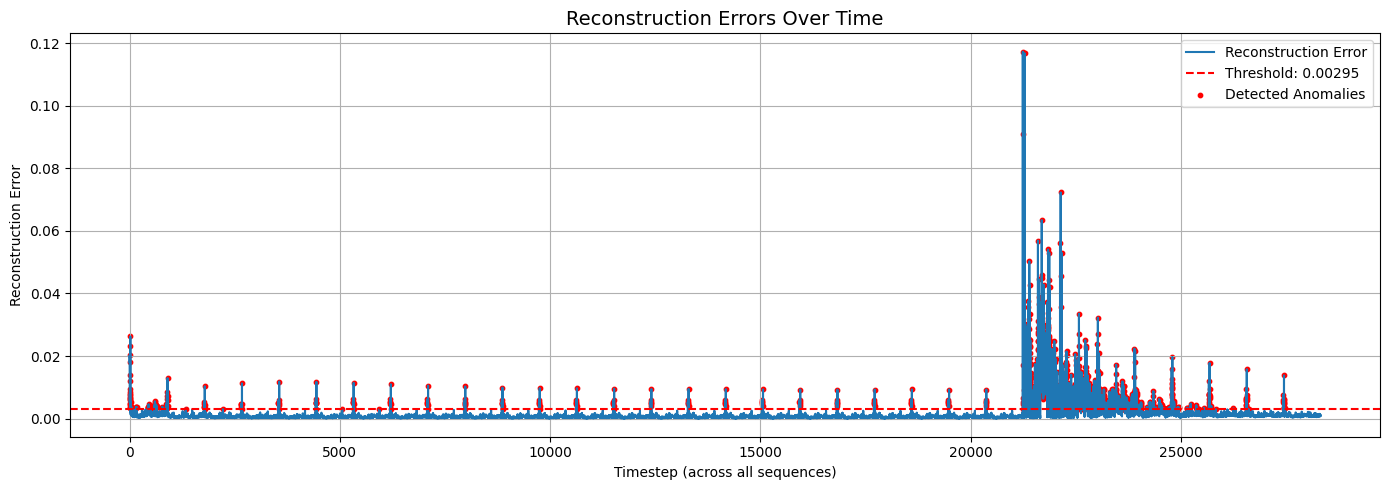

In [23]:
plt.figure(figsize=(14, 5))
# Flatten the errors to see temporal progression
plt.plot(train_errors.T.flatten(), label='Reconstruction Error')  # Transpose and flatten
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')

# For anomaly markers, need to calculate positions in flattened array
detected_positions = np.where(detected_flags.T.flatten() == 1)[0]
plt.scatter(detected_positions, train_errors.T.flatten()[detected_positions], 
            color='red', label='Detected Anomalies', s=10)

plt.title("Reconstruction Errors Over Time", fontsize=14)
plt.xlabel("Timestep (across all sequences)")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
K.clear_session()
gc.collect()

6274